### Interpolation of time dependent Eulerian fields over drifters trajectories

In [1]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import dask.dataframe as dd
from dask import delayed
import dask
from dask.distributed import wait

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.parcels as pa

import pyinterp

In [2]:
from dask.distributed import Client

if True:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
elif False:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=1, cores=4) # 4 threads per worker
    # it seems using more threads leads to a much larger memory footprint
    # production runs use only one thread
    w = cluster.scale(jobs=3)
elif False:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=4)
#
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50656,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:41071,Total threads: 7
Dashboard: http://127.0.0.1:47723/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:33952,


---

### load data

In [4]:
# Eulerian data
v = "Eta"
ds = ut.load_data_zarr(v)
grd = ut.load_grd(V=["XC", "YC"])

# Drifter data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = "time"
df = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])[parcels_index]
df = pa.degs2ms(df)

ds

<xarray.Dataset>
Dimensions:  (time: 10311, face: 13, j: 4320, i: 4320)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-11-15T14:00:00
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [5]:
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15 00:00:00,39000000,57.853661,-178.856766,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,0.012174,-0.254931,0.669059,3.904918,32.920433
2011-11-15 02:00:00,39000000,57.838902,-178.874172,0.0,-0.155116,-0.249927,0.921884,3.915445,32.918678
2011-11-15 03:00:00,39000000,57.835855,-178.893247,0.0,-0.272560,-0.153622,0.987710,3.919090,32.916588
2011-11-15 04:00:00,39000000,57.836742,-178.913583,0.0,-0.360182,-0.020691,0.826575,3.913553,32.917782


Check size of one snapshot (grid included)

In [6]:
snapshot_size = xr.merge([ds.isel(time=0), grd]).nbytes / 1e9
print(f"Snapshot size = {snapshot_size:.1f}GB")
print(f"Snapshot size x 10 = {snapshot_size*10:.1f}GB")

Snapshot size = 2.9GB
Snapshot size x 10 = 29.1GB


Treating one snapshot is thus a potentially large task in terms of memory for one workers.
It's probably going to be critical to have workers with a large amount of memory:

```
cluster = PBSCluster(processes=1, cores=1)
```


---

### local interpolation first with snapshot data

In [8]:
def interp_low(da, df, **kwargs):
    """ low level part that interpolate the field
    
    https://pangeo-pyinterp.readthedocs.io/en/latest/generated/pyinterp.RTree.inverse_distance_weighting.html#pyinterp.RTree.inverse_distance_weighting
    """
    mesh = pyinterp.RTree()
    mesh.packing(np.vstack((da.XC.values.flatten(), 
                            da.YC.values.flatten())
                          ).T,
                 da.values.flatten(),
    )

    dkwargs = dict(within=True, radius=None, k=8, num_threads=0)
    # num_threads=0 uses all cpus, set to 1 if you don't want this
    # !! should try num_threads=1, as threads seem to use a significant amount of memory
    dkwargs.update(**kwargs)
    idw_eta, neighbors = mesh.inverse_distance_weighting(
        np.vstack((df["lon"], df["lat"])).T,
        **dkwargs
    )
    df_out = df["trajectory"].to_frame()
    df_out.loc[:, da.name+"_interpolated"] = idw_eta[:]
    return df_out

Actually start computing here, skip if need be

In [14]:
t = df.index.unique().compute().dropna()[1]
da = xr.merge([ds.sel(time=t), grd])[v].compute()
df1 = df.loc[str(t)].compute()
df1.loc[:,["lon", "lat"]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49869 entries, 2011-11-15 01:00:00 to 2011-11-15 01:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     49869 non-null  float64
 1   lat     49869 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


One snapshot of Lagrangian data thus has a very small memory footprint

In [59]:
%%time
# 1min33 with threads=0
# 1min33 with threads=1
# 1min28s with threads=1, radius=10e3
# 1min33s with threads=1, radius=10e3, k=4
kwargs = dict(num_threads=1)
#kwargs = dict(num_threads=1, radius=10e3)
kwargs = dict(num_threads=1, radius=10e3, k=4)
df1.loc[:, v+"_interpolated"] = interp_low(da, df1, **kwargs).loc[:, v+"_interpolated"]
df1.loc[:,["lon", "lat"]].info()
# max to 30GB usage

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49869 entries, 2011-11-15 01:00:00 to 2011-11-15 01:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     49869 non-null  float64
 1   lat     49869 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB
CPU times: user 1min 28s, sys: 10.6 s, total: 1min 39s
Wall time: 1min 33s


In [60]:
df1.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interpolated
time,,,,,,,,,,
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,0.012174,-0.254931,0.669059,3.904918,32.920433,0.922120
2011-11-15 01:00:00,39000001,58.451424,-178.884643,0.0,-0.364250,0.026674,0.666457,4.363524,32.890057,0.915872
2011-11-15 01:00:00,39000002,59.031884,-178.889452,0.0,-0.281095,-0.122620,0.848578,4.498655,32.812191,1.089943
2011-11-15 01:00:00,39000003,59.618245,-178.894018,0.0,-0.216739,-0.030797,0.864910,4.443063,32.765560,1.105618
2011-11-15 01:00:00,39000004,60.200614,-178.904429,0.0,-0.208151,0.156184,0.801729,4.429498,32.855030,1.041577


### synthethize with plots

Checks the interpolation is correct

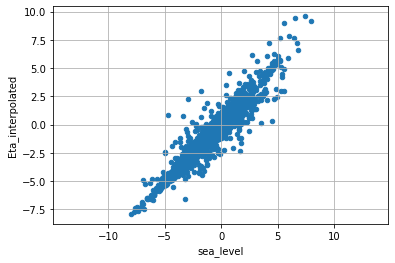

In [61]:
ax = df1.plot.scatter("sea_level","Eta_interpolated")
ax.axis("equal")
ax.grid()

In [46]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

_df = df1.dropna()
x = _df.sea_level.values[:,None]
y = _df.Eta_interpolated.values[:,None]
regressor.fit(x, y)

LinearRegression()

In [49]:
_df.loc[:,"Eta_bis"] = regressor.predict(y)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [50]:
_df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interpolated,Eta_bis
time,,,,,,,,,,,
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,0.012174,-0.254931,0.669059,3.904918,32.920433,0.922040,0.917794
2011-11-15 01:00:00,39000001,58.451424,-178.884643,0.0,-0.364250,0.026674,0.666457,4.363524,32.890057,0.915943,0.911689
2011-11-15 01:00:00,39000002,59.031884,-178.889452,0.0,-0.281095,-0.122620,0.848578,4.498655,32.812191,1.089637,1.085580
2011-11-15 01:00:00,39000003,59.618245,-178.894018,0.0,-0.216739,-0.030797,0.864910,4.443063,32.765560,1.105790,1.101750
2011-11-15 01:00:00,39000004,60.200614,-178.904429,0.0,-0.208151,0.156184,0.801729,4.429498,32.855030,1.041566,1.037454


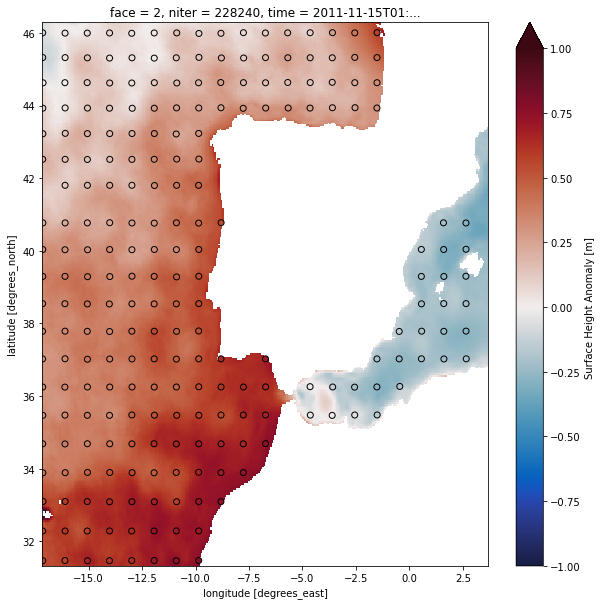

In [62]:
_da = da.sel(face=2).isel(i=slice(1000,2000,3), j=slice(1000,2000,3))

bounds = [float(_da.XC.min()), float(_da.XC.max()), 
          float(_da.YC.min()), float(_da.YC.max())]
_df = df1.loc[ (df1.lon>bounds[0]) & (df1.lon<bounds[1]) 
              & (df1.lat>bounds[2]) & (df1.lat<bounds[3])]

kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)

fig, ax = plt.subplots(1,1, figsize=(10,10))
_da.plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(_df.lon, _df.lat, c=_df.Eta_interpolated, edgecolors="k", **kwargs)

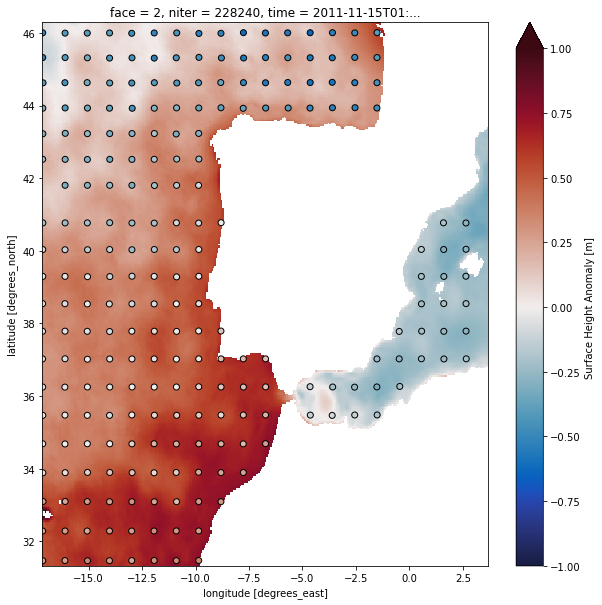

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_da.plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(_df.lon, _df.lat, c=_df.sea_level, edgecolors="k", **kwargs)

---
## distributed work

Note:

- may need to rechunk Eulerian data to have proper temporal snapshots
- processes=2, cores=2 may go through but risky. It turns out it is too risky and workers die.

In [37]:
t = df.index.unique().compute().dropna().to_numpy()
# note: there are NaN in the time series

In [38]:
#nprocesses = 2
nprocesses = len(client.scheduler_info()["workers"])
splits = np.array_split(t, len(t)//(nprocesses-1))

In [11]:
def interp(da, df, **kwargs):
    with dask.config.set(schedulers='threads'):
        if "XC" not in da.coords:
            grd = ut.load_grd(V=["XC", "YC"])
            da = da.assign_coords(XC=grd["XC"], YC=grd["YC"])
        return interp_low(da, df, **kwargs)

### dev

In [81]:
s = splits[0]

In [82]:
df_split = df.loc[str(s[0]):str(s[-1])].repartition(npartitions=nprocesses).persist()
_ = wait(df_split)

In [83]:
da = ds[v].sel(time=list(s)).chunk(dict(time=1, face=-1, i=-1, j=-1))

In [84]:
values = [delayed(interp)(da.sel(time=t), df_split.loc[str(t)]) for t in s]
futures = client.compute(values)
results = client.gather(futures)

In [85]:
results[0]

,trajectory,Eta_interpolated
time,,
2011-11-15,39000000,0.670739
2011-11-15,39000001,0.666830
2011-11-15,39000002,0.851932
2011-11-15,39000003,0.863149
2011-11-15,39000004,0.797953
...,...,...
2011-11-15,9001268,0.793911
2011-11-15,9001269,-1.255311
2011-11-15,9001270,-1.033403


In [67]:
results[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49869 entries, 2011-11-15 to 2011-11-15
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lon               49869 non-null  float64
 1   lat               49869 non-null  float64
 2   Eta_interpolated  49695 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [68]:
1.5e6 * len(t) / 1e9 # GB

12.9645

The data produced overall will be about 13GB, probably more as the estimate does not take into account particle seeding.
It will be less than twice this number in any case.

The data can thus be store on the scheduler and concatenated into a dask array at the end or every once in a while.

In [34]:
df_interp = (dd.concat([dd.from_pandas(r, npartitions=1) for r in results])
             .repartition(npartitions=1)
             .persist()
            )

In [35]:
df_interp

Dask Series Structure:
npartitions=1
2011-11-15 00:00:00    float64
2011-11-15 02:00:00        ...
dtype: float64
Dask Name: repartition, 1 tasks

## production

In [ ]:
def split_process(s, df, ds):
    """ wrapping in methods helps with garbage collection ...
    """
    df_split = df.loc[str(s[0]):str(s[-1])].repartition(npartitions=nprocesses).persist()
    _ = wait(df_split)
    da = ds[v].sel(time=list(s)).chunk(dict(time=1, face=-1, i=-1, j=-1))
    
    values = [delayed(interp)(da.sel(time=t), df_split.loc[str(t)]) for t in s]
    futures = client.compute(values)
    results = client.gather(futures)
    
    df_interp = (dd.concat([dd.from_pandas(r, npartitions=1) for r in results])
             .repartition(npartitions=1)
             .persist()
            )
    return df_interp

D = []
#n=0
for s in tqdm(splits):
    
    # implement restart process
    D.append(split_process(s, df, ds))
    
    # debug
    #try:
    #    D.append(float(ds[v].sel(time=list(s)).isel(face=1).mean()))
    #except:
    #    break
    
    # could store every n loops and reset D:
    #if n%10==0:
    #    df_interp = dd.concat(D).repartition(partition_size="100MB")
    #    df_interp.to_parquet(...)
    #    D=[]
    #n+=1

  2%|▏         | 102/4321 [00:47<35:25,  1.99it/s]

There are NaNs in the time lines

In [14]:
s

array(['2011-11-17T01:00:00.000000000',                           'NaT'],
      dtype='datetime64[ns]')

In [16]:
_df = df.loc[pd.NaT,:].compute()

In [17]:
_df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
NaT,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaT,-2147483648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# concatenate into a full dataframe prior to storage
# read individual archives if necesary
df_interp = dd.concat(D).repartition(partition_size="100MB").persist()
df_interp.head()

In [17]:
df_final = dd.merge(df, df_interp, on=["time", "trajectory"], how="inner").persist()

In [18]:
df_final.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interpolated
time,,,,,,,,,,
2011-11-15 00:00:00,39000000,57.853661,-178.856766,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.670739
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,0.012174,-0.254931,0.669059,3.904918,32.920433,0.922040
2011-11-15 02:00:00,39000000,57.838902,-178.874172,0.0,-0.155116,-0.249927,0.921884,3.915445,32.918678,0.986134
2011-11-15 03:00:00,39000000,57.835855,-178.893247,0.0,-0.272560,-0.153622,0.987710,3.919090,32.916588,0.827131
2011-11-15 04:00:00,39000000,57.836742,-178.913583,0.0,-0.360182,-0.020691,0.826575,3.913553,32.917782,0.475985


In [21]:
print(f"100s per iteration over 10 workers will require {len(t)*100/10/3600:.1f} hours for {len(t)} iterations")

100s per iteration over 10 workers will require 24.0 hours for 8643 iterations


---

## combine parquets with original dataset

In [7]:
output_dir = "/home1/scratch/aponte/interp"

In [8]:
df_interp = dd.read_parquet(glob(os.path.join(output_dir, "*.parquet")))
df_merged = df.merge(df_interp, how="inner", on=["time","trajectory"]).persist()

In [10]:
df_merged.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interpolated
time,,,,,,,,,,
2011-11-15 07:00:00,39000002,59.048020,-179.016529,0.0,-0.245972,0.198746,-0.323098,4.488305,32.815502,-0.753743
2011-11-15 03:00:00,39000015,66.132842,-179.261467,0.0,0.037618,0.001659,-1.998450,-1.770702,32.615459,NaN
2011-11-15 18:00:00,39000026,60.295037,-177.936030,0.0,0.271017,0.248502,0.201826,4.194459,32.737366,0.018552
2011-11-16 01:00:00,39000028,61.390347,-177.890890,0.0,-0.030551,-0.000682,0.305603,3.186719,32.548679,0.558895
2011-11-16 01:00:00,39000028,61.390347,-177.890890,0.0,-0.030551,-0.000682,0.305603,3.186719,32.548679,0.558895


In [ ]:
# store

---

## check original dataset and compare parcels velocity field with llc one

In [5]:
# Eulerian data
V = ["Eta", "SSU", "SSV"]
ds = ut.load_data(V)
grd = ut.load_grd(V=["XC", "YC", "CS", "SN"])

# Drifter data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
parcels_index = "time"
df = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])[parcels_index]
df = pa.degs2ms(df)

ds

<xarray.Dataset>
Dimensions:  (time: 8785, face: 13, j: 4320, i: 4320, i_g: 4320, j_g: 4320)
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [26]:
t = df.index.unique().compute().dropna()[1]
ds1 = xr.merge([ds.sel(time=t), grd])
df1 = df.loc[str(t)]

ds1 = ds1.sel(face=11).isel(i=slice(1000,2000,3), j=slice(1000,2000,3))
ds1["SSU"] = ds1.SSU.rename(i_g="i")
ds1["SSV"] = ds1.SSV.rename(j_g="j")

bounds = [float(ds1.XC.min()), float(ds1.XC.max()), 
          float(ds1.YC.min()), float(ds1.YC.max())]
df1 = df1.loc[ (df1.lon>bounds[0]) & (df1.lon<bounds[1]) 
              & (df1.lat>bounds[2]) & (df1.lat<bounds[3])]

ds1["zonal_velocity"], ds1["meridional_velocity"] = ut.rotate(ds1.SSU, ds1.SSV, ds1)

ds1 = ds1.persist()
df1 = df1.compute()

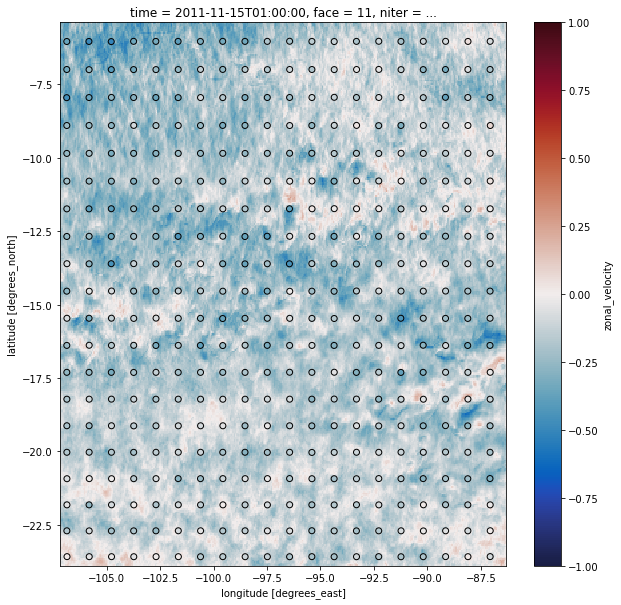

In [27]:
kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ds1["zonal_velocity"].plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(df1.lon, df1.lat, c=df1.zonal_velocity, edgecolors="k", **kwargs)

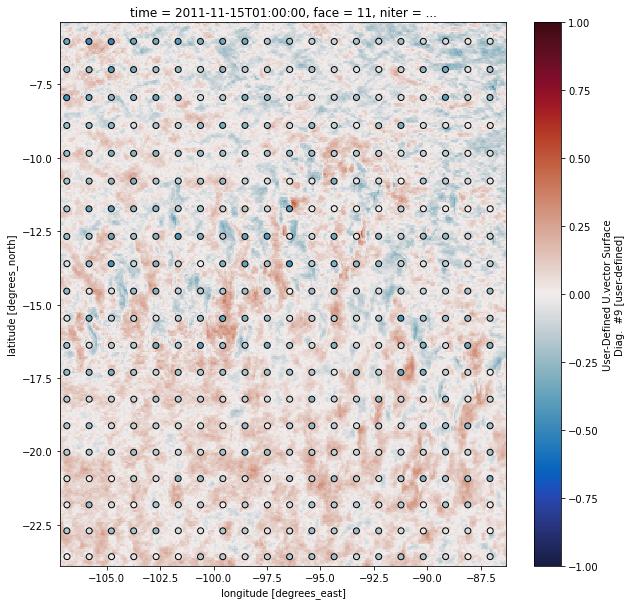

In [29]:
kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ds1["SSU"].plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(df1.lon, df1.lat, c=df1.zonal_velocity, edgecolors="k", **kwargs)

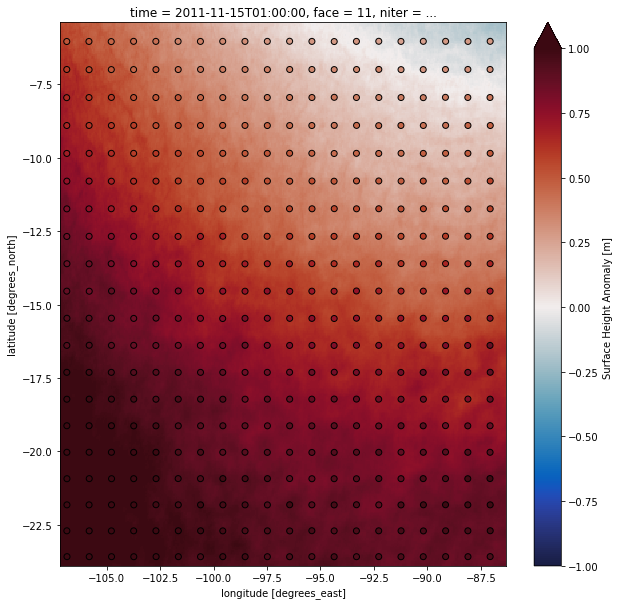

In [28]:
kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ds1["Eta"].plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(df1.lon, df1.lat, c=df1.sea_level, edgecolors="k", **kwargs)

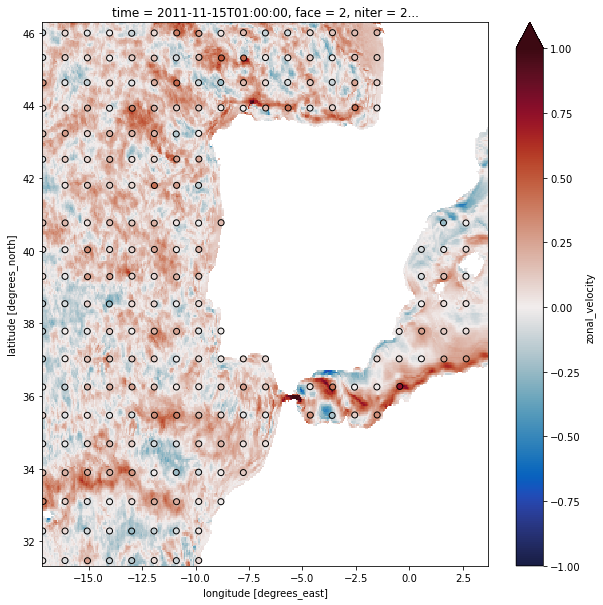

In [20]:
kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ds1["zonal_velocity"].plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(df1.lon, df1.lat, c=df1.zonal_velocity, edgecolors="k", **kwargs)

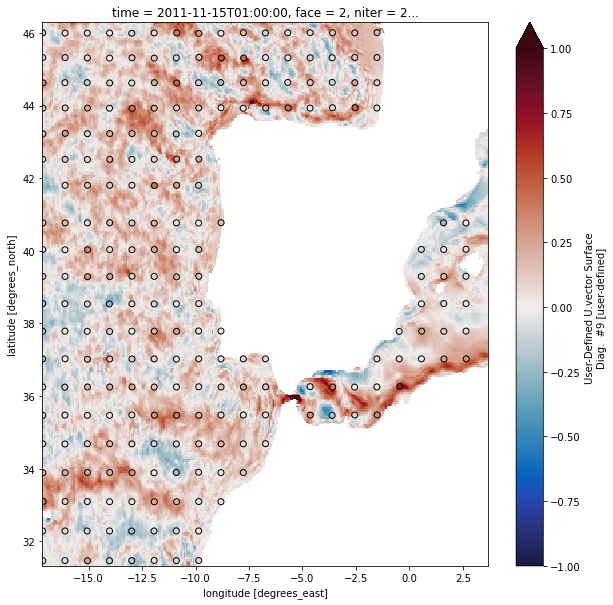

In [23]:
kwargs = dict(vmin=-1., vmax=1., cmap=pl.cm.balance)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ds1["SSU"].plot(x="XC",y="YC", ax=ax, **kwargs)
ax.scatter(df1.lon, df1.lat, c=df1.zonal_velocity, edgecolors="k", **kwargs)

---

In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
